In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

# SKLEARN modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import griddata

import sys
sys.path.append('../')
from src.utils import (
    load_dataset,
    create_folds,
    standardize_data,
    generate_data,
    create_weight_matrix,
)

from Datasets.spatial_dataset import SpatialDataset

In [2]:
# Print out the args
data_dir = "../data/boston/"
city = "boston"
window_size = 25
use_coords = False
ndvi_ls = 16
albedo_ls = 7
l2_alpha = 0.1 

In [3]:
data = load_dataset(data_dir, window_size, city)

In [4]:
print(data.coords)

[[ 483  772]
 [ 483  773]
 [ 483  774]
 ...
 [2871  644]
 [2872  640]
 [2872  641]]


In [6]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

In [8]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

# Round 1

In [9]:
lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train)
lm.coef_

array([-0.44265678, -0.17886872, -0.63603277, -0.46526224,  1.0820025 ,
        1.0078993 , -1.09039724, -0.62155265, -1.27695948, -1.76268038,
       -0.10760816,  0.46295477,  0.        , -1.10692397,  1.64109349,
       -0.18075901, -0.46366424,  0.16433648, -0.19087813])

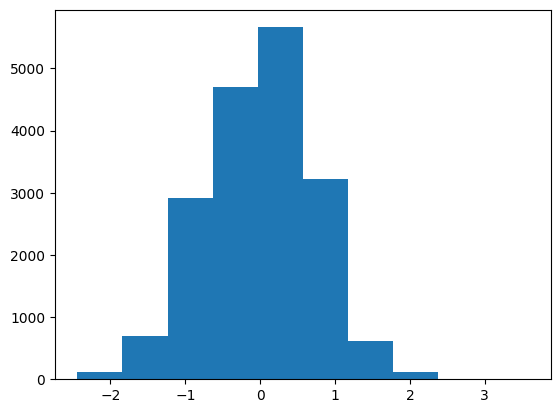

In [10]:
pred = lm.predict(x_train)
plt.hist(y_train - pred)
plt.show()

In [11]:
coords = data.coords

residuals = y_train - pred

N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [12]:
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):
    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    
    return opt_res.x, opt_res.fun

In [13]:
kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.1, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [14]:
x = np.arange(0, data.ndvi.shape[0])
y = np.arange(0, data.ndvi.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
all_coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

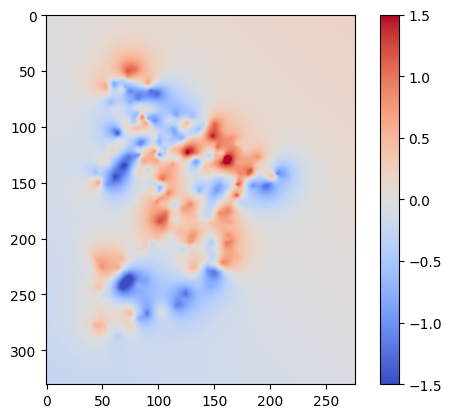

In [15]:
preds = gpr.predict(all_coords)
plt.imshow(preds.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-1.5, vmax=1.5)
plt.colorbar()

# Round 2

In [16]:
U = gpr.predict(coords)
lm2 = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train - U)
lm2.coef_

array([-0.39324096, -0.23658236, -0.77565536, -0.58420164,  0.99623352,
        0.68548382, -1.46563268, -0.76434189, -1.08346624, -1.21200326,
       -0.06665765,  0.32540229,  0.        , -0.75315459,  1.54866014,
       -0.12665352, -0.10479238, -0.07443771, -0.22351698])

In [17]:
# print out r2 score
pred = lm2.predict(x_train) #+ U
# pred_val = lm2.predict(x_val)
# print("R2 score", r2_score(y_val, pred_val ))
print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.473670678691677


In [18]:
residuals = y_train - lm2.predict(x_train)
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [21]:
kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.1, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [22]:
U = gpr.predict(coords)

# Round 3

In [23]:
lm3 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm3.coef_

array([-0.18880115, -0.03120945, -0.40802612, -0.14893795,  1.38443671,
        0.86198474, -1.26529465, -1.03880201, -0.45409096, -1.20861998,
        0.62809759,  0.35743509,  0.        , -0.50914298,  1.17951238,
       -0.12815694, -0.18750676,  0.04746299, -0.33942245])

In [30]:
# print out r2 score
pred = lm3.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.939185242562885


In [25]:
residuals = y_train - lm3.predict(x_train)

In [26]:
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [27]:
kernel = kernels.ConstantKernel(0.5, constant_value_bounds='fixed')*kernels.Matern(length_scale=150, nu=0.5, length_scale_bounds='fixed') + kernels.DotProduct(0.001, sigma_0_bounds='fixed') #+ kernels.WhiteKernel(noise_level=0.1, noise_level_bounds='fixed')
gpr = GaussianProcessRegressor(kernel = kernel, optimizer=optimizer, n_restarts_optimizer=10, random_state=100)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(kernel=0.707**2 * Matern(length_scale=150, nu=0.5) + DotProduct(sigma_0=0.001),
                         n_restarts_optimizer=10,
                         optimizer=<function optimizer at 0x0000017931B8D1C0>,
                         random_state=100)

In [28]:
U = gpr.predict(coords)

# Round 4

In [29]:
lm4 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm4.coef_

array([-0.27909262, -0.16454718, -0.41617039, -0.10628142,  1.31792547,
        0.98371173, -1.09326813, -0.85050175, -0.36653135, -0.81656331,
        0.23125867,  0.24120838,  0.        , -0.69078681,  1.1984712 ,
       -0.07844942, -0.26631924, -0.07926749, -0.30706471])

In [31]:
# print out r2 score
pred = lm4.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.9406777311321923


In [32]:
lm4.intercept_

-0.3408339211808092

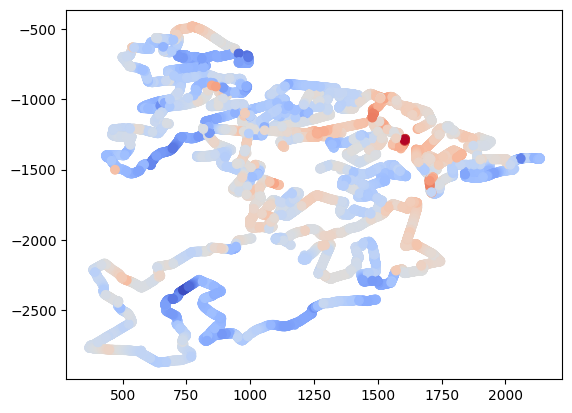

In [34]:
plt.scatter(coords[:, 1], -coords[:, 0], c=U, cmap='coolwarm')

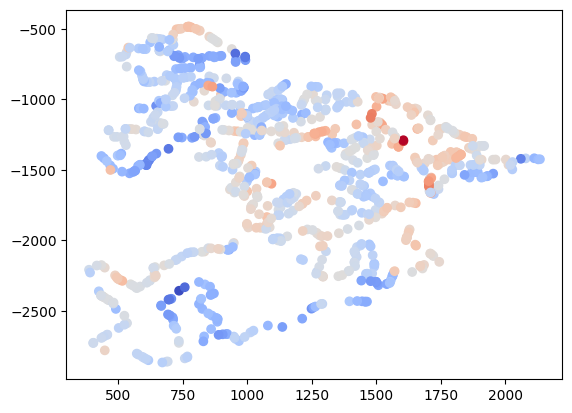

In [35]:
plt.scatter(sample_points[:, 1], -sample_points[:, 0], c=sample_residuals, cmap='coolwarm')